#Capstone Project - The Battle of Districts

Find the best place to open a Restaurant
In a city of your choice, if someone is looking to open a restaurant, where would you recommend that they open it?

---
## 1. Introduction

### 1.1. Business problem

The city chosen to answer the initial question is Seoul a capital and the most populous city in South Korea. Its continuously built-up urban area, that stretches well beyond the boundaries of the administrative metropolitan city with over 9.7 million inhabitants.

Seoul is considered a leading alpha global city, with strengths in the field of the art, commerce, design, education, entertainment, fashion, finance, healthcare, media, services, research and tourism. Its business district hosts Korea's stock exchange, and the headquarters of national and international banks and companies.

### 1.2. Target audience

A business entrepreneur that wants open a new restaurant in Seoul.

Business Analyst or Data Scientists, who wish to analyze the districts of Seoul using python, jupyter notebook and some machine learning techniques.

Someone curious about data that want to have an idea, how beneficial it is to open a restaurant and what are the pros and cons of this business.

---
## 2. Data Section
First step, let's install the python packages


In [2]:
!pip install wikipedia
!pip install folium
!pip install geopy
!pip install geopandas
!pip install geojson

and import some useful libraries

In [3]:
import pandas as pd
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None  # default='warn'


import wikipedia as wp
import requests
from bs4 import BeautifulSoup
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopandas as gpd

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

print('Libraries imported.')

Libraries imported.


First we need some information about the area of Seoul such as borough, districts, population etc... I think a good place to take a look is wikipedia

In [4]:
html = wp.page("List_of_districts_of_Seoul").html()

swiki_df = pd.read_html(html)[1]

swiki_df

,Name,Population,Area,Population density
0,Dobong-gu (도봉구; 道峰區),355712,20.70 km²,17184/km²
1,Dongdaemun-gu (동대문구; 東大門區),376319,14.21 km²,26483/km²
2,Dongjak-gu (동작구; 銅雀區),419261,16.35 km²,25643/km²
3,Eunpyeong-gu (은평구; 恩平區),503243,29.70 km²,16944/km²
4,Gangbuk-gu (강북구; 江北區),338410,23.60 km²,14339/km²
5,Gangdong-gu (강동구; 江東區),481332,24.59 km²,19574/km²
6,Gangnam-gu (강남구; 江南區),583446,39.50 km²,14771/km²
7,Gangseo-gu (강서구; 江西區),591653,41.43 km²,14281/km²
8,Geumcheon-gu (금천구; 衿川區),258030,13.02 km²,19818/km²
9,Guro-gu (구로구; 九老區),457131,20.12 km²,22720/km²


Now let's clean the dataset and add the latitude and longitude of each districts

In [5]:
swiki_df.columns = ('District', 'Population', 'Area(km2)', 'Population_Density(km2)')

swiki_df["District"] = swiki_df["District"].map(lambda value: value.split('-')[0])
swiki_df["Area(km2)"] = swiki_df["Area(km2)"].map(lambda value: value.split('k')[0])
swiki_df["Population_Density(km2)"] = swiki_df["Population_Density(km2)"].map(lambda value: value.split('/')[0])
swiki_df = swiki_df[:-1]

geo_list = []

for x in range(swiki_df.shape[0]):
  page = requests.get('https://en.wikipedia.org/wiki/'+ str(swiki_df.iloc[x][0]) + '_District')
  el = BeautifulSoup(page.content, 'html.parser').find(id='coordinates')
  if el == None:
    page = requests.get('https://en.wikipedia.org/wiki/'+ str(swiki_df.iloc[x][0]) + '_District,_Seoul')
    el = BeautifulSoup(page.content, 'html.parser').find(id='coordinates').find('span', class_='geo')
    geo_list.append(el.text.split("; "))
  else:
    el = BeautifulSoup(page.content, 'html.parser').find(id='coordinates').find('span', class_='geo')
    geo_list.append(el.text.split("; "))

lat, lon = zip(*geo_list)

swiki_df['Latitude'] = lat
swiki_df['Longitude'] = lon

swiki_df['Latitude'] = swiki_df['Latitude'].astype(float)
swiki_df['Longitude'] = swiki_df['Longitude'].astype(float)

swiki_df

,District,Population,Area(km2),Population_Density(km2),Latitude,Longitude
0,Dobong,355712,20.70,17184,37.695000,127.046940
1,Dongdaemun,376319,14.21,26483,37.571000,127.009700
2,Dongjak,419261,16.35,25643,37.512403,126.939253
3,Eunpyeong,503243,29.70,16944,37.602697,126.929111
4,Gangbuk,338410,23.60,14339,37.639611,127.025656
5,Gangdong,481332,24.59,19574,37.530000,127.123890
6,Gangnam,583446,39.50,14771,37.496670,127.027500
7,Gangseo,591653,41.43,14281,37.548610,126.850830
8,Geumcheon,258030,13.02,19818,37.451853,126.902036
9,Guro,457131,20.12,22720,37.495000,126.887000


---
##3. Methodology

###3.1. Business Understanding
The aim of this project is to find the best district of Seoul to open a new restaurant.

###3.2. Analytical Approach
The total number of districts in Seoul are 24 so we need to find a way to cluster them based on their similarities, that are the number and the kind of restaurant. Briefly, after some steps of Data Cleaning and Data Exploration, I will use a K-Means algorithm to extract the clusters, produce a map and make an argument on the final result.

###3.3. Data Exploration
To explore the data, I will use “Folium” a python library that can create interactive leaflet map using coordinate data.

Create map of Seoul using latitude and longitude values

In [6]:
address = 'Seoul, KR'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Seoul are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Seoul are 37.5666791, 126.9782914.


It's pretty important to use some good visualization to understand better the area

A map of Seoul with centroids of every district:

In [7]:
map_s = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, district in zip(swiki_df['Latitude'], 
                              swiki_df['Longitude'], 
                              swiki_df['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_s)  
    
map_s

Now it's time to use the foursquare API to examinate the city of Seoul



In [8]:
CLIENT_ID = 'LH1TXEWZCYCZA3SEHWID1KLQSDF5U1K0ZPOXWTAKKMVK2NGT' # your Foursquare ID
CLIENT_SECRET = 'PCKXM005IPX5EF1TSZHWMB5NAT3LWPWNTL33X0JIRYZQCWFH' # your Foursquare Secret
VERSION = '20200605'
LIMIT = 100

Extract venues for each district in Seoul

In [9]:
def getNearbyRestaurants(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&section=food&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        resp = requests.get(url).json()["response"]
        
        if "groups" in resp:
            results = resp['groups'][0]['items']
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
s_restaurants = getNearbyRestaurants(names=swiki_df['District'],
                                         latitudes=swiki_df['Latitude'],
                                         longitudes=swiki_df['Longitude'],
                                         radius=1500)

Ok so each row is a restaurant opened in Seoul



In [12]:
print(s_restaurants.shape)
s_restaurants.head()

(1749, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Dobong,37.695,127.04694,PARIS BAGUETTE,37.683948,127.045930,Bakery
1,Dobong,37.695,127.04694,우리나라,37.701103,127.054487,BBQ Joint
2,Dobong,37.695,127.04694,산넘어남촌 의정부점,37.704067,127.047874,Korean Restaurant
3,Dobong,37.695,127.04694,도봉산갈비,37.685881,127.046143,Korean Restaurant
4,Dobong,37.695,127.04694,도봉산 산두부,37.686635,127.037702,Korean Restaurant


In [13]:
rest_unique = s_restaurants.groupby(['Venue', 
                                         'Venue Latitude', 
                                         'Venue Longitude', 
                                         'Venue Category']).size().reset_index(name='Counts') 
print(rest_unique.shape)
rest_unique.head(10)

(1701, 5)


,Venue,Venue Latitude,Venue Longitude,Venue Category,Counts
0,1984,37.557510,126.922726,Café,1
1,2046 PANSTEAK,37.528003,126.875357,Steakhouse,1
2,25카츠 (25カツ),37.544614,126.950815,Japanese Restaurant,1
3,300 Degree,37.537017,127.069152,Italian Restaurant,1
4,3일 한우국밥,37.520281,126.904182,Korean Restaurant,1
5,4 SEED cafe,37.605537,126.967410,Café,1
6,9 Ounce Burger (나인온스버거),37.477332,126.958402,Burger Joint,1
7,A TWOSOME PLACE,37.548903,126.836431,Café,1
8,A3bout coffee,37.512977,126.944124,Café,1
9,ALEX KITCHEN,37.522638,127.134021,Restaurant,1


Now let's see all the points in a map:



In [14]:
rest_map = folium.Map([latitude, longitude], zoom_start=12)

for label, lat, lng in zip(s_restaurants['Venue'], 
                           s_restaurants['Venue Latitude'], 
                           s_restaurants['Venue Longitude']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        popup=label,
        colur='red',
        fill=True,
        fill_color='green',
        fill_opacity=0.6,
        parse_html=False
    ).add_to(rest_map)

from IPython.display import display
display(rest_map)

With a group by "District", I can easly see how many places I have.
It doesn't hurt to check it out once more.

In [15]:
resDF = s_restaurants.groupby('District').size().reset_index(name='Counts') 
resDF.head(10)

,District,Counts
0,Dobong,9
1,Dongdaemun,100
2,Dongjak,100
3,Eunpyeong,22
4,Gangbuk,25
5,Gangdong,78
6,Gangnam,100
7,Gangseo,52
8,Geumcheon,9
9,Guro,47


In [16]:
venueDF = s_restaurants.groupby('Venue Category').size().reset_index(name='Counts')
venueDF.sort_values(by=['Counts'], ascending=False).head(10)

,Venue Category,Counts
37,Korean Restaurant,351
4,Bakery,180
2,BBQ Joint,155
12,Café,140
13,Chinese Restaurant,112
36,Japanese Restaurant,96
21,Fast Food Restaurant,75
40,Noodle House,56
18,Donut Shop,52
50,Seafood Restaurant,49


Let's use all the info we have to prepare the final dataset



In [17]:
s_onehot = pd.get_dummies(s_restaurants['Venue Category'])
s_onehot.insert(loc=0, column='District', value=s_restaurants['District'])
s_grouped = s_onehot.groupby('District').mean().reset_index()
s_grouped.head(10)

,District,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Bossam/Jokbal Restaurant,Breakfast Spot,Buffet,Bunsik Restaurant,Burger Joint,Burrito Place,Café,Chinese Restaurant,Comfort Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Fast Food Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,German Restaurant,Gukbap Restaurant,Halal Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Janguh Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mexican Restaurant,Noodle House,Pet Café,Pizza Place,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Samgyetang Restaurant,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Snack Place,Soba Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Thai Restaurant,Theme Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Dobong,0.00,0.000000,0.333333,0.00,0.111111,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.00,0.00,0.0,0.000000,0.00,0.00,0.000000,0.444444,0.0,0.00,0.000000,0.00,0.111111,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.0,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.00,0.0,0.000000
1,Dongdaemun,0.00,0.000000,0.050000,0.00,0.110000,0.01,0.020000,0.00,0.000000,0.000000,0.02,0.0,0.040000,0.090000,0.0,0.0,0.0,0.000000,0.010000,0.01,0.01,0.020000,0.0,0.010000,0.000000,0.00,0.020000,0.0,0.000000,0.00,0.00,0.04,0.0,0.010000,0.00,0.00,0.060000,0.270000,0.0,0.00,0.060000,0.00,0.020000,0.010000,0.010000,0.02,0.00,0.010000,0.000000,0.0,0.030000,0.00,0.02,0.0,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.01,0.0,0.010000
2,Dongjak,0.00,0.000000,0.080000,0.01,0.080000,0.00,0.000000,0.00,0.030000,0.010000,0.00,0.0,0.080000,0.090000,0.0,0.0,0.0,0.000000,0.030000,0.00,0.00,0.040000,0.0,0.010000,0.000000,0.01,0.030000,0.0,0.000000,0.00,0.00,0.00,0.0,0.020000,0.00,0.01,0.100000,0.230000,0.0,0.00,0.030000,0.00,0.010000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.040000,0.01,0.00,0.0,0.0,0.010000,0.000000,0.0,0.00,0.010000,0.0,0.00,0.0,0.030000
3,Eunpyeong,0.00,0.000000,0.045455,0.00,0.272727,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.090909,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.136364,0.0,0.000000,0.000000,0.00,0.045455,0.0,0.000000,0.00,0.00,0.00,0.0,0.000000,0.00,0.00,0.090909,0.136364,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.045455,0.00,0.00,0.0,0.0,0.045455,0.045455,0.0,0.00,0.045455,0.0,0.00,0.0,0.000000
4,Gangbuk,0.00,0.000000,0.000000,0.00,0.200000,0.00,0.000000,0.00,0.000000,0.040000,0.00,0.0,0.040000,0.000000,0.0,0.0,0.0,0.000000,0.160000,0.00,0.00,0.080000,0.0,0.000000,0.000000,0.00,0.040000,0.0,0.000000,0.00,0.00,0.00,0.0,0.000000,0.00,0.00,0.040000,0.280000,0.0,0.00,0.040000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.0,0.0,0.000000,0.040000,0.0,0.00,0.000000,0.0,0.04,0.0,0.000000
5,Gangdong,0.00,0.012821,0.038462,0.00,0.153846,0.00,0.012821,0.00,0.025641,0.012821,0.00,0.0,0.038462,0.038462,0.0,0.0,0.0,0.000000,0.025641,0.00,0.00,0.115385,0.0,0.012821,0.000000,0.00,0.012821,0.0,0.012821,0.00,0.00,0.00,0.0,0.000000,0.00,0.00,0.051282,0.256410,0.0,0.00,0.038462,0.00,0.012821,0.012821,0.025641,0.00,0.00,0.000000,0.012821,0.0,0.038462,0.00,0.00,0.0,0.0,0.025641,0.000000,0.0,0.00,0.000000,0.0,0.00,0.0,0.012821
6,Gangnam,0.01,0.000000,0.160000,0.00,0.050000,0.00,0.000000,0.01,0.010000,0.000000,0.03,0.0,0.040000,0.060000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.010000,0.000000,0.00,0.030000,0.0,0.010000,0.01,0.01,0.01,0.0,0.020000,0.01,0.00,0.070000,0.210000,0.0,0.02,0.030000,0.01,0.020000,0.010000,0.010000,0.00,0.01,0.000000,0.0

Now I need to select only the rows about restaurants.
I suppose that our stakeholders doesn't looking to open a caffè or a bakery shop



In [18]:
s_grouped = s_grouped[['District', 'Italian Restaurant', 
                            'Pizza Place', 'Restaurant', 'Japanese Restaurant', 'Seafood Restaurant', 'Sandwich Place', 'Sushi Restaurant', 
                            'Chinese Restaurant', 'Bistro', 'Burger Joint', 'Asian Restaurant', 'Diner', 'Vegetarian / Vegan Restaurant',
                            'Breakfast Spot', 'Steakhouse', 'Fast Food Restaurant', 'Food Court', 'Indian Restaurant', 
                            'Food Truck', 'Noodle House', 'Ramen Restaurant', 'American Restaurant', 'Fried Chicken Joint', 'Korean Restaurant', 'Mexican Restaurant', 'Dim Sum Restaurant',
                            'Salad Place', 'Spanish Restaurant'
                            ]]

s_grouped.head()

,District,Italian Restaurant,Pizza Place,Restaurant,Japanese Restaurant,Seafood Restaurant,Sandwich Place,Sushi Restaurant,Chinese Restaurant,Bistro,Burger Joint,Asian Restaurant,Diner,Vegetarian / Vegan Restaurant,Breakfast Spot,Steakhouse,Fast Food Restaurant,Food Court,Indian Restaurant,Food Truck,Noodle House,Ramen Restaurant,American Restaurant,Fried Chicken Joint,Korean Restaurant,Mexican Restaurant,Dim Sum Restaurant,Salad Place,Spanish Restaurant
0,Dobong,0.00,0.111111,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.0,0.00,0.00,0.0,0.000000,0.444444,0.0,0.0,0.0,0.0
1,Dongdaemun,0.01,0.020000,0.01,0.060000,0.030000,0.0,0.000000,0.090000,0.01,0.02,0.0,0.0,0.0,0.0,0.000000,0.020000,0.01,0.04,0.0,0.06,0.01,0.0,0.020000,0.270000,0.0,0.0,0.0,0.0
2,Dongjak,0.02,0.010000,0.00,0.100000,0.040000,0.0,0.000000,0.090000,0.00,0.00,0.0,0.0,0.0,0.0,0.010000,0.040000,0.01,0.00,0.0,0.03,0.00,0.0,0.030000,0.230000,0.0,0.0,0.0,0.0
3,Eunpyeong,0.00,0.000000,0.00,0.090909,0.045455,0.0,0.045455,0.090909,0.00,0.00,0.0,0.0,0.0,0.0,0.045455,0.136364,0.00,0.00,0.0,0.00,0.00,0.0,0.045455,0.136364,0.0,0.0,0.0,0.0
4,Gangbuk,0.00,0.000000,0.00,0.040000,0.000000,0.0,0.040000,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.080000,0.00,0.00,0.0,0.04,0.00,0.0,0.040000,0.280000,0.0,0.0,0.0,0.0


This function return the most common venues for each row



In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Let's use it to extract the first ten venues for every district



In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
s_sorted = pd.DataFrame(columns=columns)
s_sorted['District'] = s_grouped['District']

for ind in np.arange(s_grouped.shape[0]):
    s_sorted.iloc[ind, 1:] = return_most_common_venues(s_grouped.iloc[ind, :], num_top_venues)

Seoul's top 10 for each districts



In [21]:
s_sorted.head(10)


,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dobong,Korean Restaurant,Pizza Place,Spanish Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Japanese Restaurant,Seafood Restaurant,Sandwich Place,Sushi Restaurant,Chinese Restaurant
1,Dongdaemun,Korean Restaurant,Chinese Restaurant,Noodle House,Japanese Restaurant,Indian Restaurant,Seafood Restaurant,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Burger Joint
2,Dongjak,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Seafood Restaurant,Fast Food Restaurant,Noodle House,Fried Chicken Joint,Italian Restaurant,Food Court,Steakhouse
3,Eunpyeong,Korean Restaurant,Fast Food Restaurant,Japanese Restaurant,Chinese Restaurant,Fried Chicken Joint,Seafood Restaurant,Sushi Restaurant,Steakhouse,Spanish Restaurant,Diner
4,Gangbuk,Korean Restaurant,Fast Food Restaurant,Fried Chicken Joint,Japanese Restaurant,Noodle House,Sushi Restaurant,Spanish Restaurant,Diner,Pizza Place,Restaurant
5,Gangdong,Korean Restaurant,Fast Food Restaurant,Japanese Restaurant,Seafood Restaurant,Chinese Restaurant,Noodle House,Restaurant,Steakhouse,Sandwich Place,Food Court
6,Gangnam,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Sushi Restaurant,Fried Chicken Joint,Noodle House,Seafood Restaurant,Burger Joint,Italian Restaurant,Pizza Place
7,Gangseo,Korean Restaurant,Fast Food Restaurant,Italian Restaurant,Steakhouse,Restaurant,Japanese Restaurant,Sushi Restaurant,Chinese Restaurant,Noodle House,Asian Restaurant
8,Geumcheon,Fast Food Restaurant,Korean Restaurant,Chinese Restaurant,Spanish Restaurant,Vegetarian / Vegan Restaurant,Pizza Place,Restaurant,Japanese Restaurant,Seafood Restaurant,Sandwich Place
9,Guro,Korean Restaurant,Fast Food Restaurant,Chinese Restaurant,Japanese Restaurant,Fried Chicken Joint,Sushi Restaurant,Steakhouse,Noodle House,Restaurant,Food Truck


###3.4. Clustering

To analyze which district of Seoul is good to open a new restaurant, I will use a K-means clustering: a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity.

So the first step is identify the best “K” using a famous analytical approach: the elbow method.

Let's see:


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


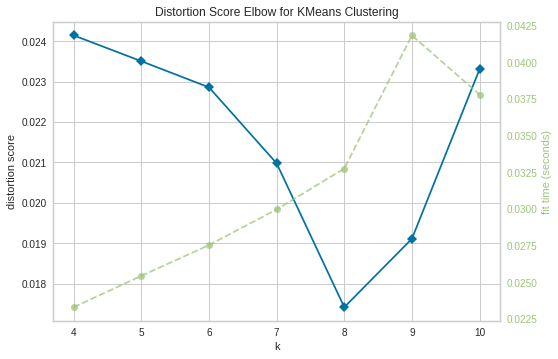

In [22]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

s_part_clustering = s_grouped.drop('District', 1)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,11))

visualizer.fit(s_part_clustering)        # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

From the plot up here, I can easily say that the best K is 8.

Now it's time to run the kmeans algorithm:

In [24]:
# set number of clusters
kclusters = 7

s_grouped_clustering = s_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(s_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 5, 4, 2, 2, 5, 4, 3, 4], dtype=int32)

Add clustering labels



In [25]:
#s_sorted.drop(columns=['Cluster Labels'], inplace=True)
s_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Merge with swiki_df to obtain the final result

In [27]:
s_complete = swiki_df.join(s_sorted.set_index('District'), on='District')
s_complete['Cluster Labels'] = s_complete['Cluster Labels'].fillna(0)
s_complete['Cluster Labels'] = s_complete['Cluster Labels'].astype(int)

s_complete.head()

,District,Population,Area(km2),Population_Density(km2),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dobong,355712,20.70,17184,37.695000,127.046940,0,Korean Restaurant,Pizza Place,Spanish Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Japanese Restaurant,Seafood Restaurant,Sandwich Place,Sushi Restaurant,Chinese Restaurant
1,Dongdaemun,376319,14.21,26483,37.571000,127.009700,2,Korean Restaurant,Chinese Restaurant,Noodle House,Japanese Restaurant,Indian Restaurant,Seafood Restaurant,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Burger Joint
2,Dongjak,419261,16.35,25643,37.512403,126.939253,5,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Seafood Restaurant,Fast Food Restaurant,Noodle House,Fried Chicken Joint,Italian Restaurant,Food Court,Steakhouse
3,Eunpyeong,503243,29.70,16944,37.602697,126.929111,4,Korean Restaurant,Fast Food Restaurant,Japanese Restaurant,Chinese Restaurant,Fried Chicken Joint,Seafood Restaurant,Sushi Restaurant,Steakhouse,Spanish Restaurant,Diner
4,Gangbuk,338410,23.60,14339,37.639611,127.025656,2,Korean Restaurant,Fast Food Restaurant,Fried Chicken Joint,Japanese Restaurant,Noodle House,Sushi Restaurant,Spanish Restaurant,Diner,Pizza Place,Restaurant


##4. Result and Discussion
Before to start to analyze all the clusters, let’s take a look on a folium map:



In [32]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(s_complete['Latitude'], s_complete['Longitude'], s_complete['District'], s_complete['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

As we can see, each cluster belong to a color with different characteristics.



In [34]:
s_complete.head(10)

,District,Population,Area(km2),Population_Density(km2),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dobong,355712,20.70,17184,37.695000,127.046940,0,Korean Restaurant,Pizza Place,Spanish Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Japanese Restaurant,Seafood Restaurant,Sandwich Place,Sushi Restaurant,Chinese Restaurant
1,Dongdaemun,376319,14.21,26483,37.571000,127.009700,2,Korean Restaurant,Chinese Restaurant,Noodle House,Japanese Restaurant,Indian Restaurant,Seafood Restaurant,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Burger Joint
2,Dongjak,419261,16.35,25643,37.512403,126.939253,5,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Seafood Restaurant,Fast Food Restaurant,Noodle House,Fried Chicken Joint,Italian Restaurant,Food Court,Steakhouse
3,Eunpyeong,503243,29.70,16944,37.602697,126.929111,4,Korean Restaurant,Fast Food Restaurant,Japanese Restaurant,Chinese Restaurant,Fried Chicken Joint,Seafood Restaurant,Sushi Restaurant,Steakhouse,Spanish Restaurant,Diner
4,Gangbuk,338410,23.60,14339,37.639611,127.025656,2,Korean Restaurant,Fast Food Restaurant,Fried Chicken Joint,Japanese Restaurant,Noodle House,Sushi Restaurant,Spanish Restaurant,Diner,Pizza Place,Restaurant
5,Gangdong,481332,24.59,19574,37.530000,127.123890,2,Korean Restaurant,Fast Food Restaurant,Japanese Restaurant,Seafood Restaurant,Chinese Restaurant,Noodle House,Restaurant,Steakhouse,Sandwich Place,Food Court
6,Gangnam,583446,39.50,14771,37.496670,127.027500,5,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Sushi Restaurant,Fried Chicken Joint,Noodle House,Seafood Restaurant,Burger Joint,Italian Restaurant,Pizza Place
7,Gangseo,591653,41.43,14281,37.548610,126.850830,4,Korean Restaurant,Fast Food Restaurant,Italian Restaurant,Steakhouse,Restaurant,Japanese Restaurant,Sushi Restaurant,Chinese Restaurant,Noodle House,Asian Restaurant
8,Geumcheon,258030,13.02,19818,37.451853,126.902036,3,Fast Food Restaurant,Korean Restaurant,Chinese Restaurant,Spanish Restaurant,Vegetarian / Vegan Restaurant,Pizza Place,Restaurant,Japanese Restaurant,Seafood Restaurant,Sandwich Place
9,Guro,457131,20.12,22720,37.495000,126.887000,4,Korean Restaurant,Fast Food Restaurant,Chinese Restaurant,Japanese Restaurant,Fried Chicken Joint,Sushi Restaurant,Steakhouse,Noodle House,Restaurant,Food Truck


Let's take a look on the clusters



In [49]:
s_complete.loc[s_complete['Cluster Labels'] == 0, s_complete.columns[[1] + list(range(4, s_complete.shape[1]))]]

,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,355712,37.695,127.04694,0,Korean Restaurant,Pizza Place,Spanish Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Japanese Restaurant,Seafood Restaurant,Sandwich Place,Sushi Restaurant,Chinese Restaurant


In [50]:
s_complete.loc[s_complete['Cluster Labels'] == 1, s_complete.columns[[1] + list(range(4, s_complete.shape[1]))]]

,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,377375,37.53790,127.08210,1,Chinese Restaurant,Korean Restaurant,Italian Restaurant,Fast Food Restaurant,Japanese Restaurant,Sushi Restaurant,Asian Restaurant,Pizza Place,Restaurant,Noodle House
18,320861,37.57917,126.93667,1,Korean Restaurant,Chinese Restaurant,Fast Food Restaurant,Italian Restaurant,Japanese Restaurant,Noodle House,Pizza Place,Restaurant,American Restaurant,Sandwich Place


In [48]:
 s_complete.loc[s_complete['Cluster Labels'] == 2, s_complete.columns[[1] + list(range(4, s_complete.shape[1]))]]

,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,376319,37.571000,127.009700,2,Korean Restaurant,Chinese Restaurant,Noodle House,Japanese Restaurant,Indian Restaurant,Seafood Restaurant,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Burger Joint
4,338410,37.639611,127.025656,2,Korean Restaurant,Fast Food Restaurant,Fried Chicken Joint,Japanese Restaurant,Noodle House,Sushi Restaurant,Spanish Restaurant,Diner,Pizza Place,Restaurant
5,481332,37.530000,127.123890,2,Korean Restaurant,Fast Food Restaurant,Japanese Restaurant,Seafood Restaurant,Chinese Restaurant,Noodle House,Restaurant,Steakhouse,Sandwich Place,Food Court
17,454288,37.483610,127.032500,2,Korean Restaurant,Seafood Restaurant,Noodle House,Chinese Restaurant,Burger Joint,Sushi Restaurant,Pizza Place,Restaurant,Japanese Restaurant,Asian Restaurant
20,303891,37.563330,127.036940,2,Korean Restaurant,Fast Food Restaurant,Seafood Restaurant,Fried Chicken Joint,Food Truck,Burger Joint,Chinese Restaurant,Steakhouse,Sandwich Place,Asian Restaurant
24,249914,37.538330,126.965560,2,Korean Restaurant,Chinese Restaurant,Noodle House,Japanese Restaurant,Seafood Restaurant,Fast Food Restaurant,Ramen Restaurant,Dim Sum Restaurant,Fried Chicken Joint,Sushi Restaurant


In [51]:
 s_complete.loc[s_complete['Cluster Labels'] == 3, s_complete.columns[[1] + list(range(4, s_complete.shape[1]))]]

,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,258030,37.451853,126.902036,3,Fast Food Restaurant,Korean Restaurant,Chinese Restaurant,Spanish Restaurant,Vegetarian / Vegan Restaurant,Pizza Place,Restaurant,Japanese Restaurant,Seafood Restaurant,Sandwich Place
14,423411,37.606400,127.092600,3,Fast Food Restaurant,Pizza Place,Korean Restaurant,Steakhouse,Spanish Restaurant,Diner,Restaurant,Japanese Restaurant,Seafood Restaurant,Sandwich Place


In [52]:
 s_complete.loc[s_complete['Cluster Labels'] == 4, s_complete.columns[[1] + list(range(4, s_complete.shape[1]))]]

,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,503243,37.602697,126.929111,4,Korean Restaurant,Fast Food Restaurant,Japanese Restaurant,Chinese Restaurant,Fried Chicken Joint,Seafood Restaurant,Sushi Restaurant,Steakhouse,Spanish Restaurant,Diner
7,591653,37.548610,126.850830,4,Korean Restaurant,Fast Food Restaurant,Italian Restaurant,Steakhouse,Restaurant,Japanese Restaurant,Sushi Restaurant,Chinese Restaurant,Noodle House,Asian Restaurant
9,457131,37.495000,126.887000,4,Korean Restaurant,Fast Food Restaurant,Chinese Restaurant,Japanese Restaurant,Fried Chicken Joint,Sushi Restaurant,Steakhouse,Noodle House,Restaurant,Food Truck
16,586056,37.654192,127.056794,4,Korean Restaurant,Fast Food Restaurant,Japanese Restaurant,Italian Restaurant,Fried Chicken Joint,Steakhouse,Seafood Restaurant,Noodle House,American Restaurant,Pizza Place
22,490708,37.516872,126.866397,4,Korean Restaurant,Fast Food Restaurant,Chinese Restaurant,Sushi Restaurant,Fried Chicken Joint,Salad Place,Italian Restaurant,Food Court,Asian Restaurant,Steakhouse


In [53]:
 s_complete.loc[s_complete['Cluster Labels'] == 5, s_complete.columns[[1] + list(range(4, s_complete.shape[1]))]]

,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,419261,37.512403,126.939253,5,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Seafood Restaurant,Fast Food Restaurant,Noodle House,Fried Chicken Joint,Italian Restaurant,Food Court,Steakhouse
6,583446,37.496670,127.027500,5,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Sushi Restaurant,Fried Chicken Joint,Noodle House,Seafood Restaurant,Burger Joint,Italian Restaurant,Pizza Place
10,531960,37.478400,126.951600,5,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Fast Food Restaurant,Burger Joint,Spanish Restaurant,Sushi Restaurant,Italian Restaurant,Noodle House,Asian Restaurant
13,136227,37.556000,126.970000,5,Korean Restaurant,Chinese Restaurant,Seafood Restaurant,Japanese Restaurant,Italian Restaurant,Bistro,Noodle House,Ramen Restaurant,Sandwich Place,Sushi Restaurant
15,395830,37.563800,126.908400,5,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Italian Restaurant,Sandwich Place,Sushi Restaurant,Ramen Restaurant,Noodle House,Vegetarian / Vegan Restaurant,Breakfast Spot
19,475961,37.589170,127.018330,5,Korean Restaurant,Noodle House,Chinese Restaurant,Fast Food Restaurant,Indian Restaurant,Japanese Restaurant,Fried Chicken Joint,Sandwich Place,Burger Joint,Sushi Restaurant
21,671794,37.514170,127.106670,5,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Italian Restaurant,Seafood Restaurant,Sandwich Place,Indian Restaurant,Restaurant,Burger Joint,Fast Food Restaurant
23,421436,37.526390,126.896390,5,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Asian Restaurant,Restaurant,Seafood Restaurant,Noodle House,Italian Restaurant,Pizza Place,Fried Chicken Joint


In [54]:
 s_complete.loc[s_complete['Cluster Labels'] == 6, s_complete.columns[[1] + list(range(4, s_complete.shape[1]))]]

,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,165344,37.59944,126.97472,6,Korean Restaurant,Italian Restaurant,Chinese Restaurant,Japanese Restaurant,Restaurant,Fried Chicken Joint,Noodle House,Burger Joint,Pizza Place,Seafood Restaurant



##5. Conclusion

As the analysis is performed on small set of data, we can achieve better results by increasing the district information (see the next chapter). Anyway Seoul is an international city with many different types of new restaurant business to offer and I think we have gone through the process of identifying the business problem, specifying the data required, clean the datasets, performing a machine learning algorithm using k-means clustering and providing some useful tips to our stakeholder.


##6. Next Developments
Next steps I recommend would be:

* Use a different Venue API with more data. Unfortunately foursquare isn’t pretty famous in Korea.

* Mostly users prefer Google Maps or Facebook.

* Find and use updated demographics data about Milan’s Neighborhood.

* Try a Neighborhood-Based Clustering.